In [1]:
import os
import sys
sys.path.append("/home/ubuntu/workspace/code/compositional-representation-learning")

In [3]:
import random
import itertools

import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from vector_quantize_pytorch import VectorQuantize

from datasets import v0Dataset

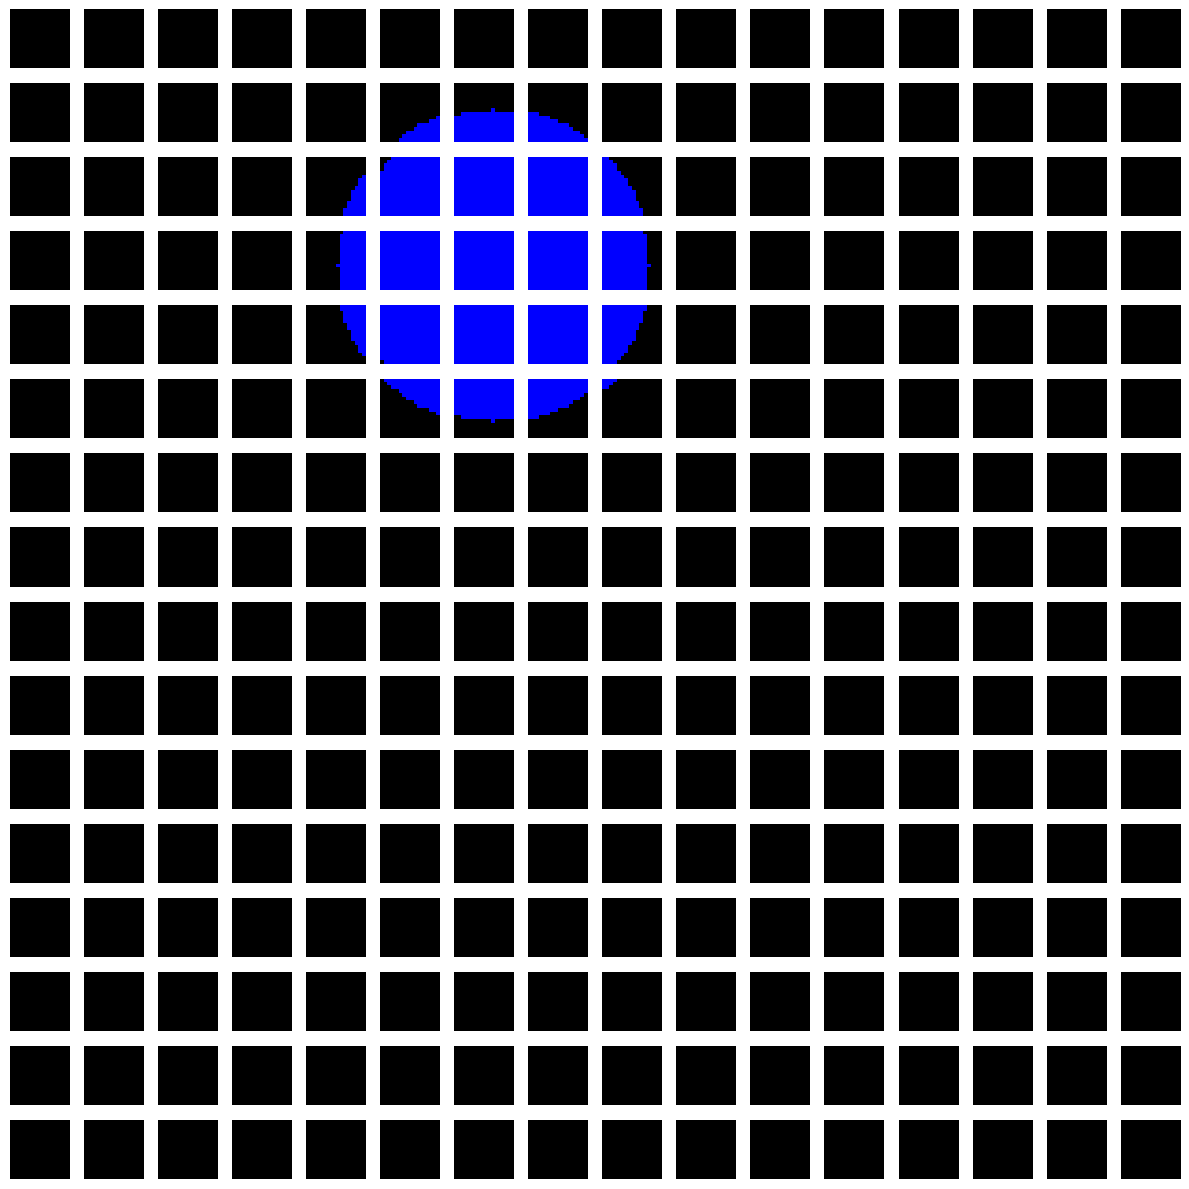

In [4]:
grid_size = (16, 16)

ds_config = {
    "image_size": [256, 256, 3],
    "shapes": ["circle", "square"],
    "colors": ["red", "blue"],
    "num_samples": 1000
}

ds = v0Dataset(ds_config)

datapoint = ds[0]

image = datapoint["images"].permute(1, 2, 0).cpu().numpy()

h, w = image.shape[:2]
grid_h, grid_w = grid_size

region_height = h // grid_h
region_width = w // grid_w

regions = []
for i in range(grid_h):
    for j in range(grid_w):
        y_start = i * region_height
        y_end = (i + 1) * region_height
        x_start = j * region_width
        x_end = (j + 1) * region_width
        region = image[y_start:y_end, x_start:x_end, :]
        regions.append(region)

fig, axes = plt.subplots(grid_h, grid_w, figsize=(12, 12))
for idx, region in enumerate(regions):
    i = idx // grid_w
    j = idx % grid_w
    axes[i, j].imshow(region)
    axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [5]:
grid_size = (16, 16)

def divide_image_into_patches(images):
    B, C, H, W = images.shape
    
    grid_h, grid_w = grid_size
    patch_h = H // grid_h
    patch_w = W // grid_w

    if H % grid_h != 0 or W % grid_w != 0:
        raise ValueError("Image dimensions must be divisible by grid size.")

    patches = images.view(B, C, grid_h, patch_h, grid_w, patch_w) # (B, C, grid_h, patch_h, grid_w, patch_w)
    patches = patches.permute(0, 2, 4, 1, 3, 5) # (B, grid_h, grid_w, C, patch_h, patch_w)
    patches = patches.contiguous()
    
    return patches

datapoint = ds[0]
image = datapoint["images"].unsqueeze(0)
object_mask = datapoint["object_masks"].unsqueeze(0)

image_patches = divide_image_into_patches(image)
mask_patches = divide_image_into_patches(object_mask.unsqueeze(1))

In [8]:
mask_patches_sum = mask_patches.sum(dim = (-1, -2, -3))

In [15]:
non_empty_patch_mask = (mask_patches_sum > 0)

In [19]:
B, grid_h, grid_w = non_empty_patch_mask.shape
y_coords = torch.arange(grid_h).view(1, grid_h, 1).expand(B, grid_h, grid_w)
x_coords = torch.arange(grid_w).view(1, 1, grid_w).expand(B, grid_h, grid_w)

y_coords_masked_min = torch.where(non_empty_patch_mask, y_coords, grid_h + 1)
x_coords_masked_min = torch.where(non_empty_patch_mask, x_coords, grid_w + 1)
y_coords_masked_max = torch.where(non_empty_patch_mask, y_coords, -1)
x_coords_masked_max = torch.where(non_empty_patch_mask, x_coords, -1)

# Find min/max across all grid positions (flattened)
y_min = y_coords_masked_min.view(B, -1).min(dim=1).values
x_min = x_coords_masked_min.view(B, -1).min(dim=1).values
y_max = y_coords_masked_max.view(B, -1).max(dim=1).values
x_max = x_coords_masked_max.view(B, -1).max(dim=1).values

# Clamp values to handle empty items gracefully
y_min = torch.clamp(y_min, 0, grid_h)
x_min = torch.clamp(x_min, 0, grid_w)
y_max = torch.clamp(y_max, -1, grid_h -1)
x_max = torch.clamp(x_max, -1, grid_w -1)

In [22]:
bbox = torch.stack([y_min, x_min, y_max, x_max], dim = -1) # (B, 4)
bbox

tensor([[ 9,  4, 12,  7]])

In [ ]:
bbox_ = bbox[0]
image_patches[0][bbox_[0]:bbox_[2]+1, bbox_[1]:bbox_[3]+1].shape

torch.Size([3, 3, 3, 16, 16])

In [ ]:
image_patches[0][]

torch.Size([16, 16, 3, 16, 16])

In [ ]:
y_coords = torch.arange(grid_h).view(1, grid_h, 1).expand(B, grid_h, grid_w)

In [24]:
image_size = (256, 256, 3)
shapes = ["circle", "square"]
colors = [(255, 0, 0), (0, 0, 255)]

def generate_image():
    image = np.zeros(image_size, dtype=np.uint8)
    mask = np.zeros(image_size[0:2], dtype=np.uint8)
    
    shape = random.choice(shapes)
    color = random.choice(colors)
    
    if shape == "circle":
        radius = np.random.randint(10, 50)
        center = (np.random.randint(radius, image_size[1] - radius), np.random.randint(radius, image_size[0] - radius))
        cv2.circle(image, center, radius, color, -1)
        cv2.circle(mask, center, radius, 255, -1)
    elif shape == "square":
        side_length = np.random.randint(10, 50)
        top_left = (np.random.randint(0, image_size[1] - side_length), np.random.randint(0, image_size[0] - side_length))
        cv2.rectangle(image, top_left, (top_left[0] + side_length, top_left[1] + side_length), color, -1)
        cv2.rectangle(mask, top_left, (top_left[0] + side_length, top_left[1] + side_length), 255, -1)
    
    return image, mask

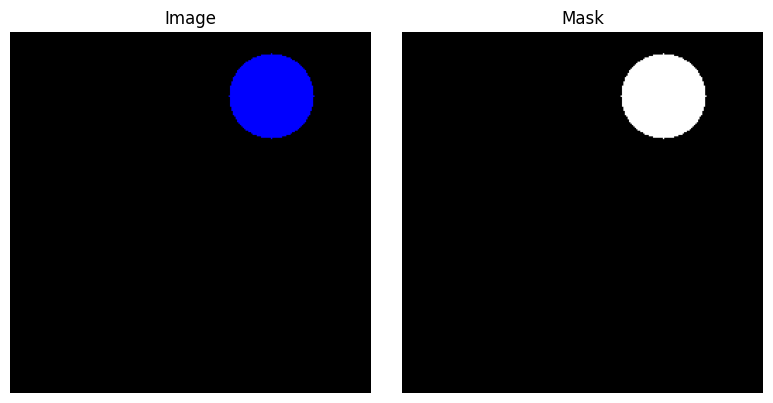

In [26]:
image, mask = generate_image()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()


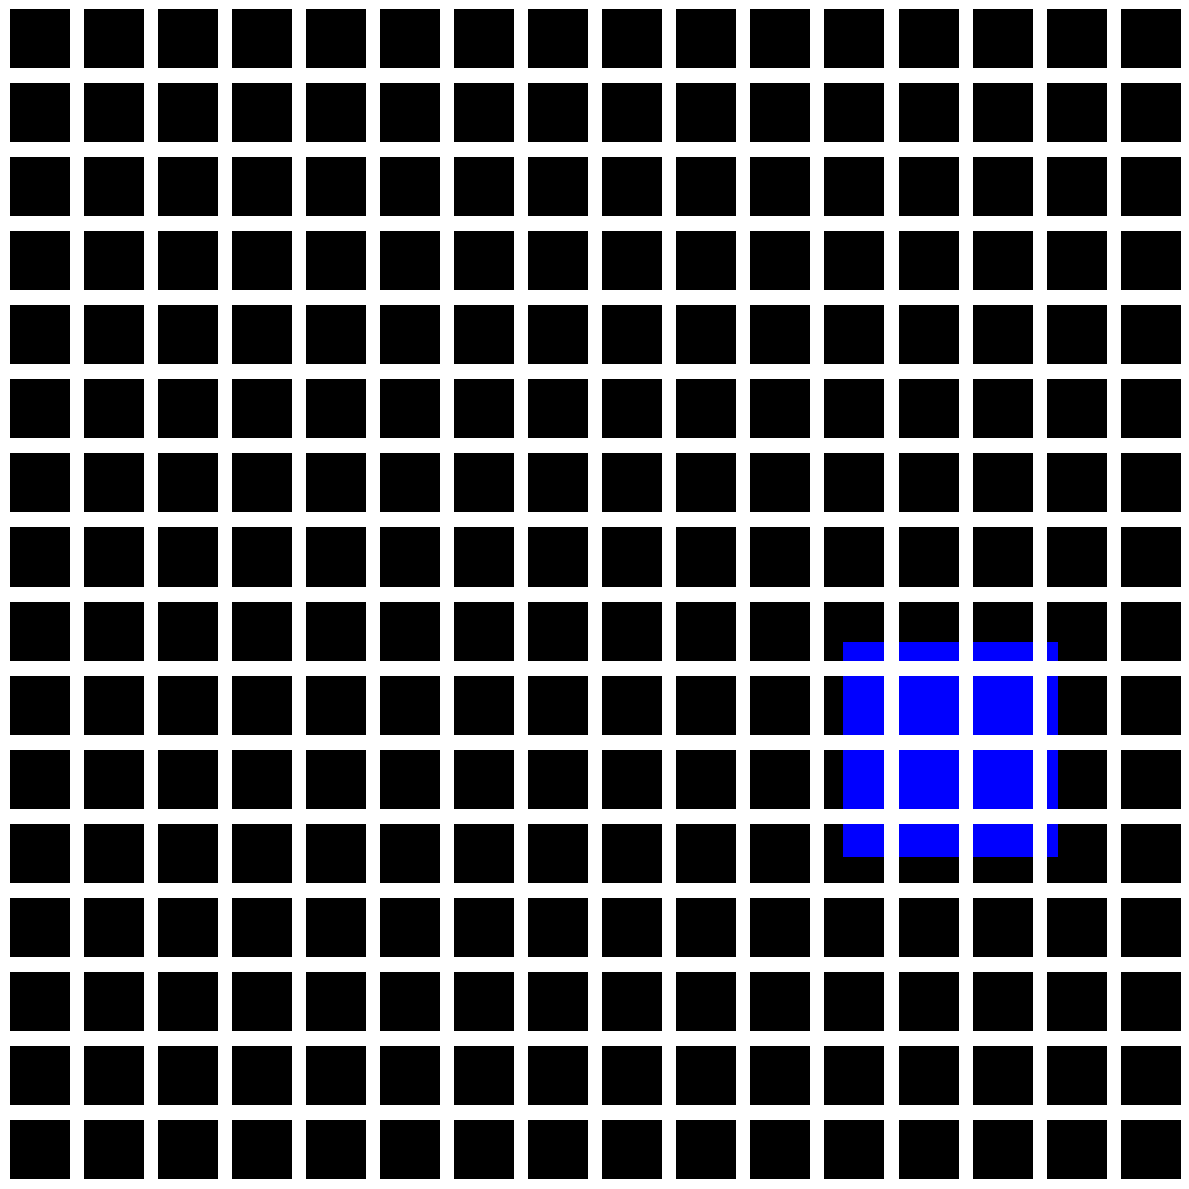

In [27]:
grid_size = (16, 16)
grid_h, grid_w = grid_size

def divide_image_into_patches(image, grid_size):
    h, w = image.shape[:2]
    grid_h, grid_w = grid_size
    
    patch_height = h // grid_h
    patch_width = w // grid_w
    
    patches = {}

    for i in range(grid_h):
        for j in range(grid_w):
            y_start = i * patch_height
            y_end = (i + 1) * patch_height
            x_start = j * patch_width
            x_end = (j + 1) * patch_width
            patch = image[y_start:y_end, x_start:x_end, :]
            grid_position = (i, j)
            patches[grid_position] = patch
    return patches

image, mask = generate_image()
patches = divide_image_into_patches(image, grid_size)

fig, axes = plt.subplots(grid_h, grid_w, figsize=(12, 12))
for grid_position, patch in patches.items():
    i, j = grid_position
    axes[i, j].imshow(patch)
    axes[i, j].axis('off')
plt.tight_layout()

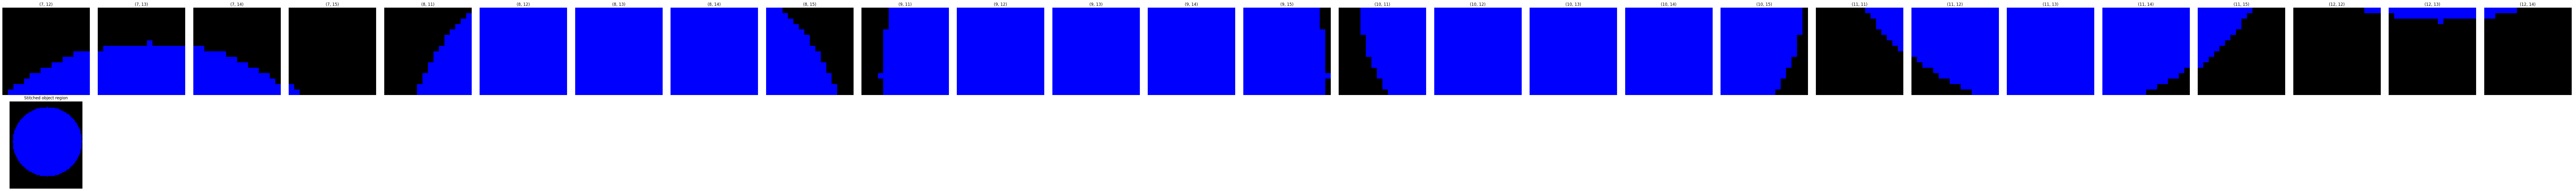

In [28]:
def process_data(image, mask):
    patches = divide_image_into_patches(image, grid_size)

    non_empty_patches = {grid_position: patch for grid_position, patch in patches.items() if patch.sum() != 0}
    non_empty_indices = list(non_empty_patches.keys())

    object_patch_y_min = np.array(non_empty_indices)[:, 0].min()
    object_patch_x_min = np.array(non_empty_indices)[:, 1].min()
    object_patch_y_max = np.array(non_empty_indices)[:, 0].max()
    object_patch_x_max = np.array(non_empty_indices)[:, 1].max()

    object_patch_bbox = np.array([object_patch_y_min, object_patch_x_min, object_patch_y_max, object_patch_x_max])

    # Take patches within the min/max bounds and stitch them together
    selected_patches = []
    for i in range(object_patch_y_min, object_patch_y_max + 1):
        row_patches = []
        for j in range(object_patch_x_min, object_patch_x_max + 1):
            patch = patches.get((i, j))
            if patch is not None:
                row_patches.append(patch)
            else:
                raise ValueError(f"There is no valid patch at {i, j}")
        
        if row_patches:
            row_stitched = np.concatenate(row_patches, axis=1)
            selected_patches.append(row_stitched)
        else:
            raise ValueError(f"There are no valid patches in row {i}")

    if selected_patches:
        object_region = np.concatenate(selected_patches, axis=0)
    else:
        raise ValueError("There are no valid patches in the object region")

    return patches, non_empty_patches, object_region, object_patch_bbox


image, mask = generate_image()
patches, non_empty_patches, object_region, object_patch_bbox = process_data(image, mask)

fig, axes = plt.subplots(2, max(len(non_empty_patches), 1), figsize=(4 * len(non_empty_patches), 8))

# Plot all non-empty patches in the top row
if len(non_empty_patches) == 1:
    axes_top = [axes[0]]
    axes_bottom = [axes[1]]
else:
    axes_top = axes[0]
    axes_bottom = axes[1]

for idx, (grid_position, patch) in enumerate(non_empty_patches.items()):
    axes_top[idx].imshow(patch)
    axes_top[idx].set_title(f"{grid_position}")
    axes_top[idx].axis('off')

# Plot the object region below, spanning all columns
for ax in axes_bottom:
    ax.axis('off')
if len(non_empty_patches) > 1:
    obj_ax = axes_bottom[0]
    obj_ax.imshow(object_region)
    obj_ax.set_title("Stitched object region")
else:
    axes_bottom[0].imshow(object_region)
    axes_bottom[0].set_title("Stitched object region")
plt.tight_layout()
plt.show()

In [33]:
from torch import nn
import torch.nn.functional as F

class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = "same")
        self.conv_2 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = "same")

        self.maxpool_1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_3 = nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride = 1, padding = "same")
        self.conv_4 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, stride = 1, padding = "same")

        self.maxpool_2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_5 = nn.Conv2d(in_channels = 12, out_channels = 20, kernel_size = 3, stride = 1, padding = "same")
        self.conv_6 = nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, stride = 1, padding = "same")

        self.maxpool_3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_7 = nn.Conv2d(in_channels = 20, out_channels = 32, kernel_size = 3, stride = 1, padding = "same")
        self.conv_8 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = "same")

        self.maxpool_4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_9 = nn.Conv2d(in_channels = 32, out_channels = 48, kernel_size = 3, stride = 1, padding = "same")
        self.conv_10 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 1, stride = 1, padding = "same")

        self.maxpool_5 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_11 = nn.Conv2d(in_channels = 48, out_channels = 64, kernel_size = 3, stride = 1, padding = "same")
        self.conv_12 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = "same")

        self.maxpool_6 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_13 = nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, stride = 1, padding = "same")
        self.conv_14 = nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 1, stride = 1, padding = "same")

        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(96 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim)
        )

        self.layers = nn.Sequential(
            self.conv_1,
            nn.ReLU(),
            self.conv_2,
            nn.ReLU(),
            self.maxpool_1,
            nn.ReLU(),
            self.conv_3,
            nn.ReLU(),
            self.conv_4,
            nn.ReLU(),
            self.maxpool_2,
            nn.ReLU(),
            self.conv_5,
            nn.ReLU(),
            self.conv_6,
            nn.ReLU(),
            self.maxpool_3,
            nn.ReLU(),
            self.conv_7,
            nn.ReLU(),
            self.conv_8,
            nn.ReLU(),
            self.maxpool_4,
            nn.ReLU(),
            self.conv_9,
            nn.ReLU(),
            self.conv_10,
            nn.ReLU(),
            self.maxpool_5,
            nn.ReLU(),
            self.conv_11,
            nn.ReLU(),
            self.conv_12,
            nn.ReLU(),
            self.maxpool_6,
            nn.ReLU(),
            self.conv_13,
            nn.ReLU(),
            self.conv_14,
            self.flatten,
            self.mlp
        )

    def forward(self, x):

        x = self.layers(x)

        return x


class PositionEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class BindingFunction(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [32]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [34]:
image_encoder = ImageEncoder(6)
position_encoder = PositionEncoder(2, 6, 32)
binding_function = BindingFunction(12, 6, 32)

image_encoder.to("cuda")
position_encoder.to("cuda")
binding_function.to("cuda")

BindingFunction(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [35]:
# Initialize VQ module and move to GPU
embed_dim = 3
box_embed_dim = embed_dim * 2

vq = VectorQuantize(
    dim = box_embed_dim,
    codebook_size = 512,
    decay = 0.8,
    commitment_weight = 1.
).to("cuda")

# Create Adam optimizer for all trainable parameters
optimizer = torch.optim.Adam(
    list(image_encoder.parameters()) + 
    list(position_encoder.parameters()) + 
    list(binding_function.parameters()) +
    [vq.codebook],  # Include the codebook for training
    lr=1e-4
)

# Loss weights for computing total loss
loss_weights = {
    "codebook_positive_volume_loss": 0.1,
    "pos_commitment_loss": 1.0,
    "patch_commitment_loss": 1.0,
    "object_region_commitment_loss": 1.0,
    "parent_commitment_loss": 1.0,
    "fundamental_embeddings_separation_loss": 0.5,
    "parent_permutation_separation_loss": 1.0,
    "object_region_alignment_loss": 1.0,
}


In [ ]:
EMBED_DIM = 3
BOX_EMBED_DIM = EMBED_DIM * 2

def split_box_embeddings(box_embeddings):
    return box_embeddings[..., :EMBED_DIM], box_embeddings[..., EMBED_DIM:]

def compute_overall_intersection_box(box_embeddings):
    boxes_min, boxes_max = split_box_embeddings(box_embeddings) # (N, 3), (N, 3)
    intersection_min = torch.max(boxes_min, dim = 0).values.unsqueeze(0) # (1, 3)
    intersection_max = torch.min(boxes_max, dim = 0).values.unsqueeze(0) # (1, 3)
    intersection_box = torch.cat([intersection_min, intersection_max], dim = -1) # (1, 6)
    
    return intersection_box

def compute_index_pair_intersection_boxes(box_embeddings_1, box_embeddings_2):
    boxes_min_1, boxes_max_1 = split_box_embeddings(box_embeddings_1)  # [N, 3], [N, 3]
    boxes_min_2, boxes_max_2 = split_box_embeddings(box_embeddings_2)  # [N, 3], [N, 3]

    intersection_min = torch.max(boxes_min_1, boxes_min_2)  # [N, 3]
    intersection_max = torch.min(boxes_max_1, boxes_max_2)  # [N, 3]
    intersection_boxes = torch.cat([intersection_min, intersection_max], dim=-1)  # [N, 6]
    
    return intersection_boxes

def compute_pairwise_intersection_boxes(box_embeddings_1, box_embeddings_2):
    boxes_min_1, boxes_max_1 = split_box_embeddings(box_embeddings_1) # [N, 3], [N, 3]
    boxes_min_2, boxes_max_2 = split_box_embeddings(box_embeddings_2) # [N, 3], [N, 3]

    boxes_min_1_i = boxes_min_1.unsqueeze(1) # [N, 1, 3]
    boxes_min_2_j = boxes_min_2.unsqueeze(0) # [1, N, 3]
    boxes_max_1_i = boxes_max_1.unsqueeze(1) # [N, 1, 3]
    boxes_max_2_j = boxes_max_2.unsqueeze(0) # [1, N, 3]
    
    intersection_min = torch.max(boxes_min_1_i, boxes_min_2_j) # [N, N, 3]
    intersection_max = torch.min(boxes_max_1_i, boxes_max_2_j) # [N, N, 3]
    intersection_boxes = torch.cat([intersection_min, intersection_max], dim=-1) # [N, N, 6]

    return intersection_boxes

def separation_loss(box_embeddings, margin = 0.1):
    num_boxes = box_embeddings.shape[0]
    boxes_min, boxes_max = split_box_embeddings(box_embeddings)
    box_centers = (boxes_min + boxes_max) / 2.0
    dists = torch.cdist(box_centers, box_centers)
    loss = F.relu(margin - dists)
    loss = torch.sum(loss) / (num_boxes * (num_boxes - 1))

    return torch.sum(loss)

def compute_box_volume(box_embeddings):
    boxes_min, boxes_max = split_box_embeddings(box_embeddings)
    box_sizes = boxes_max - boxes_min
    return torch.prod(box_sizes, dim=-1)

def positive_volume_loss(box_embeddings, min_side = 0.1):
    num_boxes = box_embeddings.shape[0]
    boxes_min, boxes_max = split_box_embeddings(box_embeddings)
    box_sizes = boxes_max - boxes_min
    loss = F.relu(min_side - box_sizes)
    loss = torch.sum(loss) / num_boxes

    return torch.sum(loss)

def compute_index_pair_inclusion_loss(box_embeddings_1, box_embeddings_2):
    boxes_min_1, boxes_max_1 = split_box_embeddings(box_embeddings_1)  # parent (N, 3), (N, 3)
    boxes_min_2, boxes_max_2 = split_box_embeddings(box_embeddings_2)  # child (N, 3), (N, 3)

    min_violation = F.relu(boxes_min_1 - boxes_min_2)  # violation where parent's min > child's min, shape (N, 3)
    max_violation = F.relu(boxes_max_2 - boxes_max_1)  # violation where child's max > parent's max, shape (N, 3)

    loss = min_violation.sum(dim=-1) + max_violation.sum(dim=-1)  # (N,)

    return loss

def compute_permutation_indices(num_elements):
    permutations = list(itertools.permutations(range(num_elements)))
    cols = torch.tensor(permutations, dtype=torch.long)
    rows = torch.arange(num_elements, dtype=torch.long).unsqueeze(0).expand(len(permutations), -1)
    indices = torch.stack([rows, cols], dim=-1)

    return indices


In [ ]:
# Training loop
num_steps = 1000
batch_size = 32

# Initialize loss history to track losses across steps
loss_history = []

for idx in range(num_steps):
    # Zero gradients at the start of each step
    optimizer.zero_grad()

    # Compute codebook positive volume loss at the start of each step
    codebook_embeddings = vq.codebook  # shape: (codebook_size, box_embed_dim)
    codebook_pos_vol_loss = positive_volume_loss(codebook_embeddings, min_side=0.1)

    # Initialize batch loss accumulators (as tensors for backprop)
    batch_loss_tensors = {
        "codebook_positive_volume_loss": codebook_pos_vol_loss,
        "pos_commitment_loss": torch.tensor(0.0, device="cuda"),
        "patch_commitment_loss": torch.tensor(0.0, device="cuda"),
        "object_region_commitment_loss": torch.tensor(0.0, device="cuda"),
        "parent_commitment_loss": torch.tensor(0.0, device="cuda"),
        "fundamental_embeddings_separation_loss": torch.tensor(0.0, device="cuda"),
        "parent_permutation_separation_loss": torch.tensor(0.0, device="cuda"),
        "object_region_alignment_loss": torch.tensor(0.0, device="cuda"),
    }

    for datapoint_idx in range(batch_size):
        image, mask = generate_image()
        patches, non_empty_patches, object_region, object_patch_bbox = process_data(image, mask)

        patch_position_data = []
        patch_data = []

        for patch_idx, patch in non_empty_patches.items():
            relative_patch_idx = np.array([patch_idx[0] - object_patch_bbox[0], patch_idx[1] - object_patch_bbox[1]])
            denom = np.array([object_patch_bbox[2] - object_patch_bbox[0], object_patch_bbox[3] - object_patch_bbox[1]])
            denom = np.where(denom == 0, 1, denom)  # Prevent division by zero
            relative_patch_idx = relative_patch_idx / denom + [0.5, 0.5]

            patch_position_data.append(relative_patch_idx)
            # patch = Image.fromarray(patch)
            patch_data.append(image_transform(patch))

        patch_position_data = torch.tensor(np.array(patch_position_data), dtype=torch.float32).to("cuda")
        patch_data = torch.stack(patch_data).to("cuda")
        object_region_data = image_transform(object_region).to("cuda").unsqueeze(0)

        position_embeddings = position_encoder(patch_position_data) # [N, 6]
        patch_embeddings = image_encoder(patch_data) # [N, 6]
        object_region_embedding = image_encoder(object_region_data) # [1, 6]

        quantized_position_embeddings, _, pos_commitment_loss = vq(position_embeddings) # [N, 6]
        quantized_patch_embeddings, _, patch_commitment_loss = vq(patch_embeddings) # [N, 6]
        quantized_object_region_embedding, _, object_region_commitment_loss = vq(object_region_embedding) # [1, 6]

        unique_quantized_patch_embeddings, unique_indices = torch.unique(quantized_patch_embeddings, dim=0, return_inverse=True) # [num_unique, 6], [N]
        fundamental_embeddings = torch.cat([quantized_position_embeddings, unique_quantized_patch_embeddings], dim = 0) # [N + num_unique, 6]
        fundamental_embeddings_min, fundamental_embeddings_max = split_box_embeddings(fundamental_embeddings) # [N + num_unique, 3], [N + num_unique, 3]
        fundamental_embeddings_centers = (fundamental_embeddings_min + fundamental_embeddings_max) / 2.0 # [N + num_unique, 3]
        fundamental_embeddings_distance_margin = 0.1
        fundamental_embeddings_pairwise_distances = torch.pdist(fundamental_embeddings_centers, p=2) # [N + num_unique, N + num_unique]
        fundamental_embeddings_separation_loss = F.relu(fundamental_embeddings_distance_margin - fundamental_embeddings_pairwise_distances) # [N + num_unique, N + num_unique]
        fundamental_embeddings_separation_loss = torch.sum(fundamental_embeddings_separation_loss) / (fundamental_embeddings_centers.shape[0] * (fundamental_embeddings_centers.shape[0] - 1)) # scalar

        num_elements = quantized_position_embeddings.shape[0]
        pos_expand = quantized_position_embeddings.unsqueeze(1).expand(-1, num_elements, -1)  # (N, N, 6)
        patch_expand = quantized_patch_embeddings.unsqueeze(0).expand(num_elements, -1, -1)  # (N, N, 6)
        dense_concat = torch.cat([pos_expand, patch_expand], dim=-1)  # (N, N, 12)
        parent_embeddings = binding_function(dense_concat.view(num_elements * num_elements, -1)) # (N * N, 6)
        parent_embeddings, _, parent_commitment_loss = vq(parent_embeddings)
        parent_embeddings = parent_embeddings.view(num_elements, num_elements, -1) # (N, N, 6)

        parent_intersection_boxes = compute_pairwise_intersection_boxes(quantized_position_embeddings, quantized_patch_embeddings) # [N, N, 6]
        parent_inclusion_loss = compute_index_pair_inclusion_loss(parent_embeddings.view(num_elements * num_elements, -1), parent_intersection_boxes.view(num_elements * num_elements, -1)) # (N * N,)

        overall_intersection_box = compute_overall_intersection_box(torch.cat([quantized_position_embeddings, quantized_patch_embeddings], dim = 0)) # (1, 6)

        permutation_indices = compute_permutation_indices(num_elements)
        parent_permutation_sets = parent_embeddings[permutation_indices[..., 0], permutation_indices[..., 1]] # (N!, N, 6)

        num_permutations = parent_permutation_sets.shape[0]
        parent_permutation_intersection_boxes = []
        for i in range(num_permutations):
            permutation_set = parent_permutation_sets[i]  # shape: (N, 6)
            intersection_box = compute_overall_intersection_box(permutation_set)  # shape: (1, 6)
            parent_permutation_intersection_boxes.append(intersection_box.squeeze(0))
        parent_permutation_intersection_boxes = torch.stack(parent_permutation_intersection_boxes, dim=0)  # shape: (N!, 6)

        parent_permutation_inclusion_losses = compute_index_pair_inclusion_loss(
            parent_permutation_intersection_boxes, 
            overall_intersection_box.expand_as(parent_permutation_intersection_boxes)
        )

        parent_permutation_pairwise_intersection_boxes = compute_pairwise_intersection_boxes(
            parent_permutation_intersection_boxes,
            parent_permutation_intersection_boxes
        ) # (N!, N!, 6)

        parent_permutation_pairwise_volumes = compute_box_volume(parent_permutation_pairwise_intersection_boxes.view(-1, 6)) # (N! * N!, 1)
        parent_permutation_pairwise_volumes = parent_permutation_pairwise_volumes.view(num_permutations, num_permutations) # (N!, N!)
        
        parent_permutation_pairwise_volumes_upper = parent_permutation_pairwise_volumes.triu(diagonal=1)
        parent_permutation_separation_loss = torch.sum(parent_permutation_pairwise_volumes_upper)
        
        correct_parent_set = torch.diagonal(parent_embeddings, 0)  # shape: (N, 6)
        correct_parent_intersection_box = compute_overall_intersection_box(correct_parent_set)  # shape: (1, 6)
        object_region_alignment_loss = F.mse_loss(quantized_object_region_embedding, correct_parent_intersection_box)

        # Collect losses for this datapoint
        loss_dict = {
            "pos_commitment_loss": pos_commitment_loss,
            "patch_commitment_loss": patch_commitment_loss,
            "object_region_commitment_loss": object_region_commitment_loss,
            "parent_commitment_loss": parent_commitment_loss,
            "fundamental_embeddings_separation_loss": fundamental_embeddings_separation_loss,
            "parent_permutation_separation_loss": parent_permutation_separation_loss,
            "object_region_alignment_loss": object_region_alignment_loss,
        }

        # Accumulate losses across datapoints in the batch (as tensors)
        for key in loss_dict:
            batch_loss_tensors[key] = batch_loss_tensors[key] + loss_dict[key]

    # Average losses across the batch (except codebook loss which is per-step)
    for key in batch_loss_tensors:
        if key != "codebook_positive_volume_loss":
            batch_loss_tensors[key] = batch_loss_tensors[key] / batch_size

    # Compute total weighted loss for backpropagation
    total_loss = torch.tensor(0.0, device="cuda")
    for key, loss_value in batch_loss_tensors.items():
        total_loss = total_loss + loss_weights[key] * loss_value

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Convert losses to scalars for logging
    batch_losses = {key: value.item() for key, value in batch_loss_tensors.items()}
    batch_losses["total_loss"] = total_loss.item()

    # Store batch losses
    loss_history.append(batch_losses.copy())

    # Print progress every 10 steps
    if (idx + 1) % 10 == 0:
        print(f"Step {idx + 1}/{num_steps}")
        print(f"  Total Loss: {batch_losses['total_loss']:.6f}")
        print(f"  Codebook positive volume loss: {batch_losses['codebook_positive_volume_loss']:.6f}")
        print(f"  Other losses: {batch_losses}")
        print()

In [38]:
quantized_position_embeddings.shape, quantized_patch_embeddings.shape, quantized_object_region_embedding.shape

(torch.Size([12, 6]), torch.Size([12, 6]), torch.Size([1, 6]))

In [ ]:
# Visualize loss history
import pandas as pd

# Convert loss history to DataFrame for easier analysis
loss_df = pd.DataFrame(loss_history)

# Plot all losses including total loss
num_losses = len(loss_df.columns)
num_cols = 3
num_rows = (num_losses + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
axes = axes.flatten()

# Plot total loss first with emphasis
axes[0].plot(loss_df['total_loss'], linewidth=2, color='red')
axes[0].set_title('Total Loss (Weighted)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# Plot other losses
for idx, loss_name in enumerate([col for col in loss_df.columns if col != 'total_loss'], start=1):
    axes[idx].plot(loss_df[loss_name])
    axes[idx].set_title(loss_name, fontsize=10)
    axes[idx].set_xlabel('Step')
    axes[idx].set_ylabel('Loss')
    axes[idx].grid(True, alpha=0.3)

# Hide any remaining empty subplots
for idx in range(len(loss_df.columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nLoss Statistics (across all steps):")
print(loss_df.describe())

# Print final losses
print("\nFinal losses (last step):")
for key, value in loss_df.iloc[-1].items():
    print(f"  {key}: {value:.6f}")

(torch.Size([41, 6]), torch.Size([41, 6]), torch.Size([1, 6]))